In [1]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: alvaro-francisco-gil (orbit-generation). Use `wandb login --relogin` to force relogin


True

# Imports

In [2]:
import tensorflow as tf

# List available physical devices
gpus = tf.config.list_physical_devices('GPU')
print(f"GPUs found: {len(gpus)}")

# Print GPU details
for i, gpu in enumerate(gpus):
    print(f"GPU {i}: {gpu}")


2024-05-17 09:25:42.273871: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


GPUs found: 2
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU 1: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


2024-05-17 09:25:43.186324: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 09:25:43.186602: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 09:25:43.201989: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 09:25:43.202205: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 09:25:43.202337: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [3]:
import tensorflow as tf

# Assuming 'GPU:1' is the identifier for the second GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Disable first GPU
        tf.config.set_visible_devices(gpus[1], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("Logical GPUs:", logical_gpus)
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)


2024-05-17 09:25:43.209761: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 09:25:43.210334: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 09:25:43.210505: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 09:25:43.210592: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so ret

Logical GPUs: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [4]:
from orbit_generation.data import load_memmap_array, save_data
from orbit_generation.processing import resample_3d_array
from orbit_generation.visualize import export_dynamic_orbits_html, visualize_static_orbits
from orbit_generation.stats import plot_histograms_comparison, plot_latent_space

In [5]:
%load_ext autoreload
%autoreload 2

import numpy as np
from tensorflow import keras
import tsgm
import os

2024-05-17 09:25:47.486673: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-05-17 09:25:47.487471: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x7e32c90


In [6]:
from keras.optimizers import Adam, SGD
from wandb.integration.keras import WandbCallback

# Parameters

In [7]:
data_path = r"/orbit-generation/data/sp_dataset_em.npy"
labels_path = r"/orbit-generation/data/sp_dataset_em_labels.npy"
folder_experiments = "../experiments"

In [8]:
params = {
    'model_name': 'vae_conv5',
    'data_used': os.path.splitext(os.path.basename(data_path))[0],
    'latent_dim': 64,
    'feature_dim': 7,
    'seq_len': 300,
    'batch_size': 32,
    'epochs': 50,
    'optimizer': {
        'name': 'Adam',
        'learning_rate': 0.001
    }
}

In [9]:
# Extract relevant parameters
model_name = params['model_name']
data_used = params['data_used']

# Combine the remaining parameters into a single string to form the last subdirectory name
# Excluding 'model_name' and 'data_used' since they're used in higher-level directories
other_params = f"{params['latent_dim']}_{params['feature_dim']}_{params['seq_len']}_{params['batch_size']}_{params['epochs']}_{params['optimizer']['name']}_{params['optimizer']['learning_rate']}"

# Construct the full path for the experiment directory
experiment_folder = os.path.join(folder_experiments, model_name, data_used, other_params)

# Create the directory structure
os.makedirs(experiment_folder, exist_ok=True)

# Now you can use 'experiment_folder' to save files related to this particular experiment
print(f"Experiment directory created: {experiment_folder}")

Experiment directory created: ../experiments/vae_conv5/sp_dataset_em/64_7_300_32_50_Adam_0.001


In [10]:
# Initialize a new run
wandb.init(project='orbit-generation', entity='alvaro-francisco-gil', config=params)


wandb: Currently logged in as: alvaro-francisco-gil. Use `wandb login --relogin` to force relogin


# Data

## Imports

In [11]:
data = load_memmap_array(data_path)
data.shape

(163800, 7, 1500)

In [12]:
labels = np.load(labels_path)
labels.shape

FileNotFoundError: [Errno 2] No such file or directory: '/orbit-generation/data/sp_dataset_em_labels.mat'

## Interpolation

In [ ]:
data = resample_3d_array(data=data, axis=2, target_size=300)
data.shape

## Shuffle

In [ ]:
# Set a random seed for reproducibility
np.random.seed(42) 

# Create an array of indices based on the length of the data
indices = np.arange(data.shape[0])

# Shuffle the indices
np.random.shuffle(indices)

# Use the shuffled indices to reorder the data and labels
data = data[indices]
labels = labels[indices]

## Transpose

In [ ]:
transposed_orbits = np.transpose(data, (0, 2, 1))
del data

## Scaling

In [ ]:
scaler = tsgm.utils.TSFeatureWiseScaler()        
scaled_data = scaler.fit_transform(transposed_orbits)
del transposed_orbits
scaled_data.shape

(163800, 300, 7)

# Generation

## Define Architecture

In [ ]:
# Accessing model configuration from the zoo using parameters from the dictionary
architecture = tsgm.models.zoo[params['model_name']](
    seq_len=params['seq_len'], 
    feat_dim=params['feature_dim'], 
    latent_dim=params['latent_dim']
)

# Extracting encoder and decoder from the architecture
encoder, decoder = architecture.encoder, architecture.decoder

## Fit

In [ ]:
def get_optimizer(optimizer_config):
    name = optimizer_config['name'].lower()
    if name == 'adam':
        return Adam(learning_rate=optimizer_config.get('learning_rate', 0.001))
    elif name == 'sgd':
        return SGD(learning_rate=optimizer_config.get('learning_rate', 0.01))
    # Add additional optimizers as needed
    raise ValueError("Unsupported optimizer: {}".format(optimizer_config['name']))

In [ ]:
# Assuming encoder and decoder have been defined as part of the architecture setup
vae = tsgm.models.cvae.BetaVAE(encoder, decoder)

# Compile the VAE model with the configured optimizer from the params dictionary
optimizer = get_optimizer(params['optimizer'])
vae.compile(optimizer=optimizer)

# Fit the model using the scaled data and parameters from the dictionary
vae.fit(scaled_data, epochs=params['epochs'], batch_size=params['batch_size'], callbacks=[WandbCallback()])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/50


2024-05-09 22:26:03.375178: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-05-09 22:26:04.207576: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f5da5873230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-09 22:26:04.207598: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-05-09 22:26:04.210479: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1715293564.256272  103006 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   6/5119 [..............................] - ETA: 4:49 - loss: 1494.0552 - reconstruction_loss: 1063.4707 - kl_loss: 0.6066WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0187s vs `on_train_batch_end` time: 0.0317s). Check your callbacks.


5119/5119 [==============================] - 292s 56ms/step - loss: 111.5405 - reconstruction_loss: 50.7155 - kl_loss: 7.5756
Epoch 2/50
5119/5119 [==============================] - 287s 56ms/step - loss: 19.7831 - reconstruction_loss: 11.9318 - kl_loss: 7.3986
Epoch 3/50
5119/5119 [==============================] - 286s 56ms/step - loss: 18.0717 - reconstruction_loss: 10.1997 - kl_loss: 7.3112
Epoch 4/50
5119/5119 [==============================] - 286s 56ms/step - loss: 19.7465 - reconstruction_loss: 9.6509 - kl_loss: 7.3026
Epoch 5/50
5119/5119 [==============================] - 286s 56ms/step - loss: 17.2936 - reconstruction_loss: 10.1739 - kl_loss: 7.5135
Epoch 6/50
5119/5119 [==============================] - 286s 56ms/step - loss: 15.9364 - reconstruction_loss: 8.6388 - kl_loss: 7.1440
Epoch 7/50
5119/5119 [==============================] - 286s 56ms/step - loss: 15.6349 - reconstruction_loss: 8.3137 - kl_loss: 7.0204
Epoch 8/50
5119/5119 [==============================] - 286s 

## Save Model

In [ ]:
# Define full paths for the encoder and decoder
encoder_save_path = os.path.join(experiment_folder, 'encoder')
decoder_save_path = os.path.join(experiment_folder, 'decoder')

In [ ]:
# Save the models in the specified directory with TensorFlow format
encoder.save(encoder_save_path, save_format='tf')
decoder.save(decoder_save_path, save_format='tf')

wandb.save('encoder.h5')
wandb.save('decoder.h5')
wandb.save('generation.npy')

INFO:tensorflow:Assets written to: ../experiments/vae_conv5/sp_em/16_7_300_32_50_Adam_0.001/encoder/assets


INFO:tensorflow:Assets written to: ../experiments/vae_conv5/sp_em/16_7_300_32_50_Adam_0.001/encoder/assets


INFO:tensorflow:Assets written to: ../experiments/vae_conv5/sp_em/16_7_300_32_50_Adam_0.001/decoder/assets


INFO:tensorflow:Assets written to: ../experiments/vae_conv5/sp_em/16_7_300_32_50_Adam_0.001/decoder/assets


[]

In [ ]:
encoder = tf.keras.models.load_model(encoder_save_path)
decoder = tf.keras.models.load_model(decoder_save_path)

# Assuming encoder and decoder have been defined as part of the architecture setup
vae = tsgm.models.cvae.BetaVAE(encoder, decoder)

## Predict

In [ ]:
x_decoded = vae.predict(scaled_data)

5119/5119 [==============================] - 71s 14ms/step


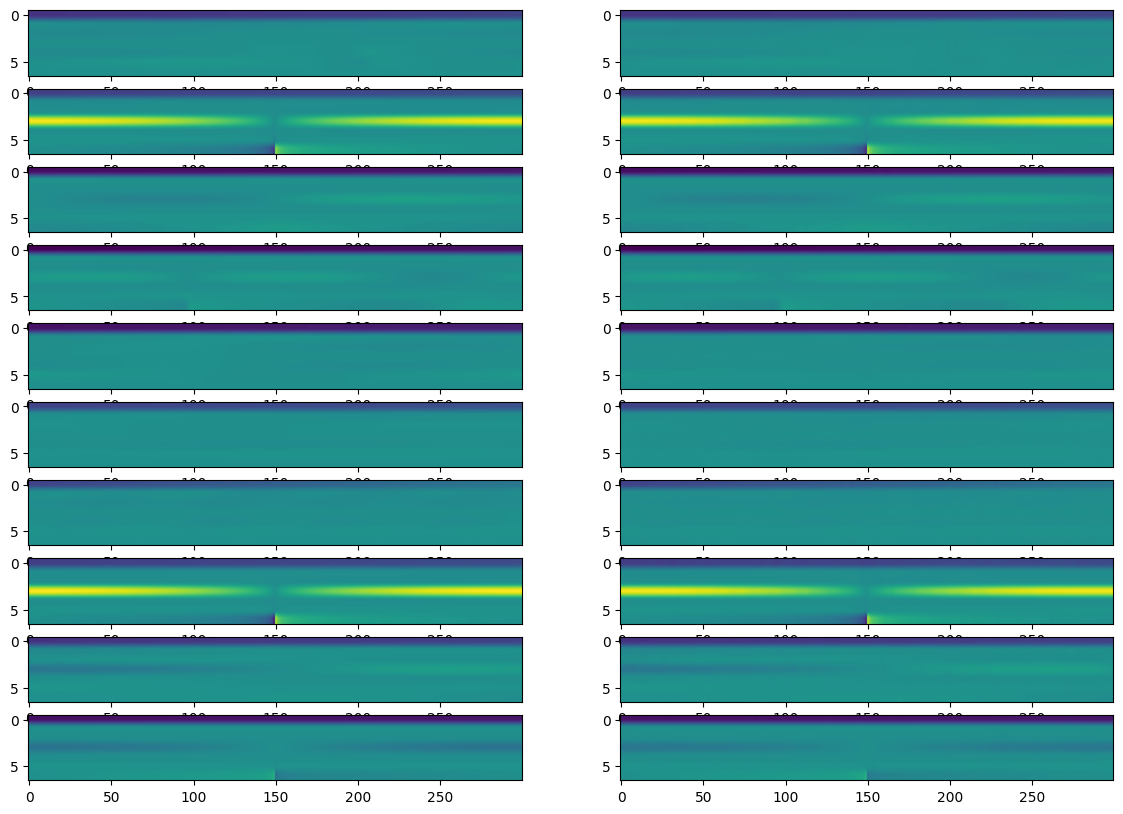

In [ ]:
tsgm.utils.visualize_original_and_reconst_ts(scaled_data, x_decoded, num=10)

## Generate

In [ ]:
# generation = vae.generate(int(data.shape[0]*0.01))
generation = vae.generate(100)
generation.shape

TensorShape([100, 300, 7])

In [ ]:
generated_data_path = os.path.join(experiment_folder, 'generated_data')

In [ ]:
inverted_generation = scaler.inverse_transform(generation)
save_data(inverted_generation, generated_data_path)

In [ ]:
# generation = np.load("/orbit-generation/experiments/vae_conv5/sp_em/16_7_300_32_50_Adam_0.001/generated_data.npy")

In [ ]:
klk

# Analysis

## Visualization

In [ ]:
no_time_generation = inverted_generation[:,:,1:]
no_time_generation.shape

TensorShape([100, 300, 6])

In [ ]:
display_generation = np.transpose(no_time_generation, (0, 2, 1))

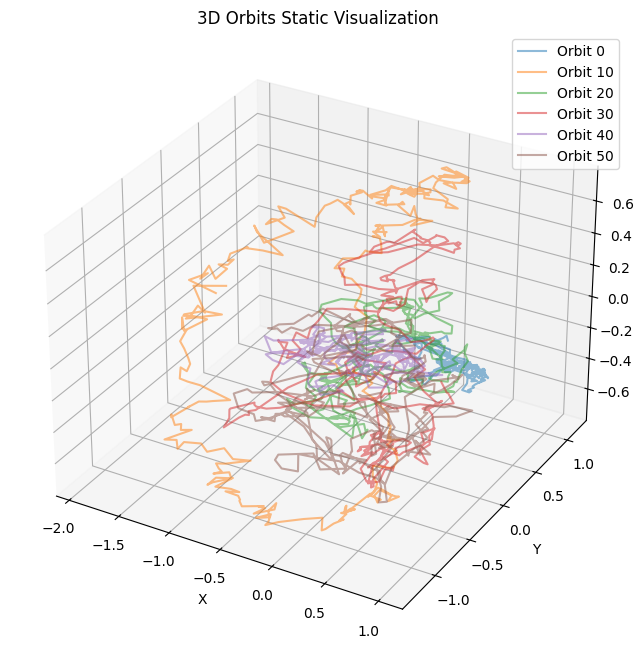

In [ ]:
visualize_static_orbits(data= display_generation, orbit_indices=[0,10,20,30,40,50])

In [ ]:
dynamic_orbits_path = os.path.join(experiment_folder, 'generated_orbits.html')
export_dynamic_orbits_html(data=display_generation, filename=dynamic_orbits_path)

Visualization saved to ../experiments/vae_conv5/sp_em/16_7_300_32_50_Adam_0.001/generated_orbits


## Coverage

In [ ]:
data = data[:,1:,:]

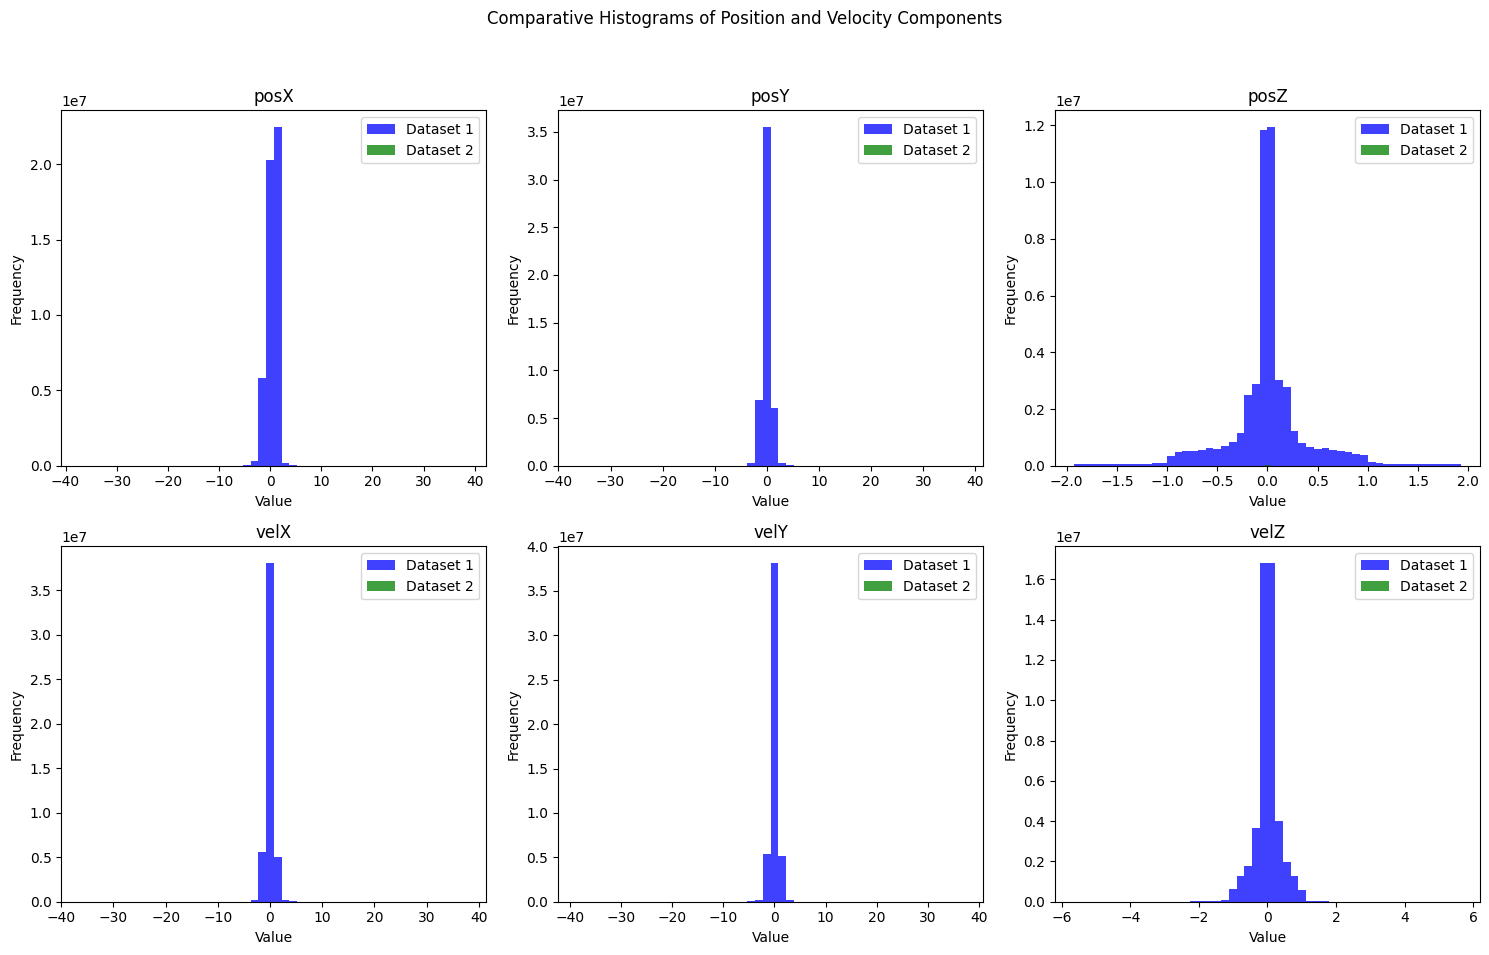

In [ ]:
plot_histograms_comparison(data, display_generation)

## Latent Visualization

In [ ]:
latent_mean, _, _ = vae.encoder(scaled_data)
latent_representations = latent_mean.numpy()

In [ ]:
plot_latent_space(latent_representations, labels, techniques=['All'], save_fig=os.path.join(experiment_folder, 'latent_space'))

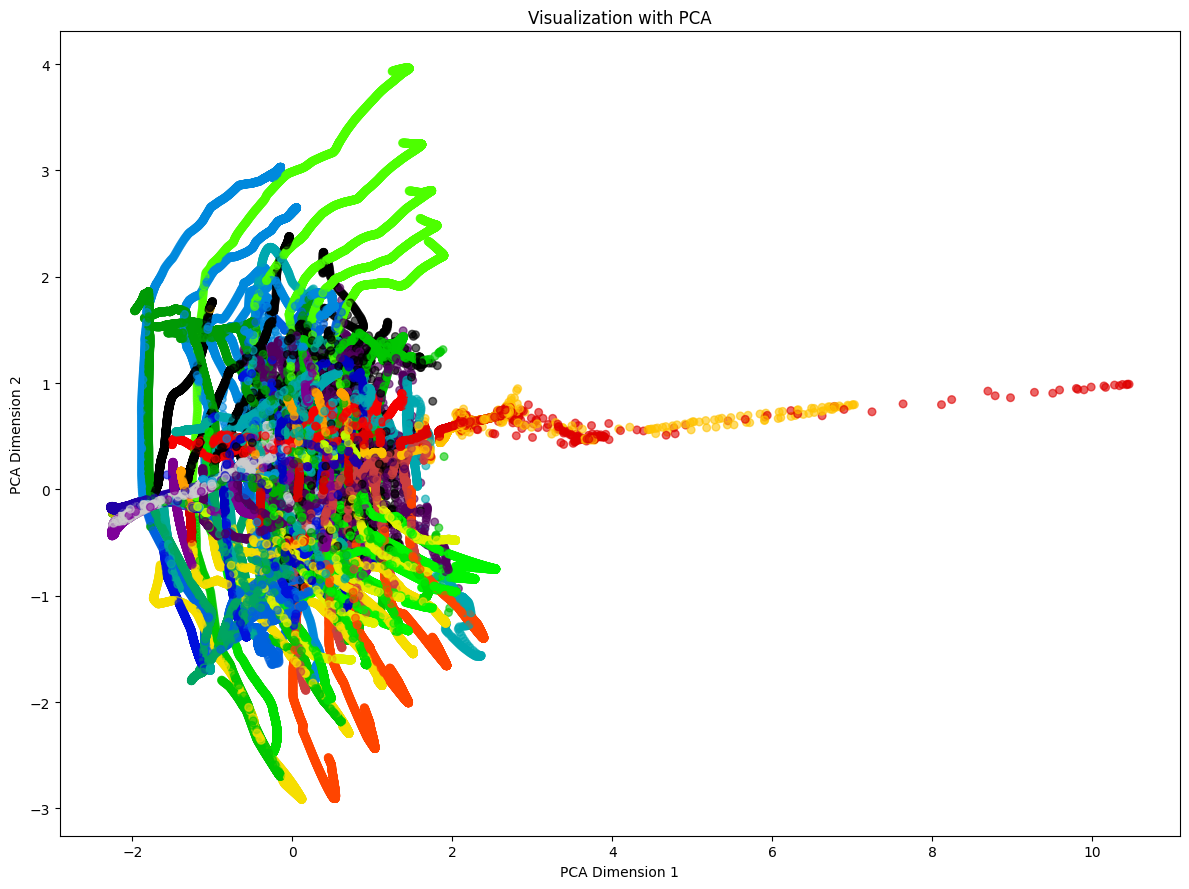

In [ ]:
plot_latent_space(latent_representations, labels, techniques=['PCA'])

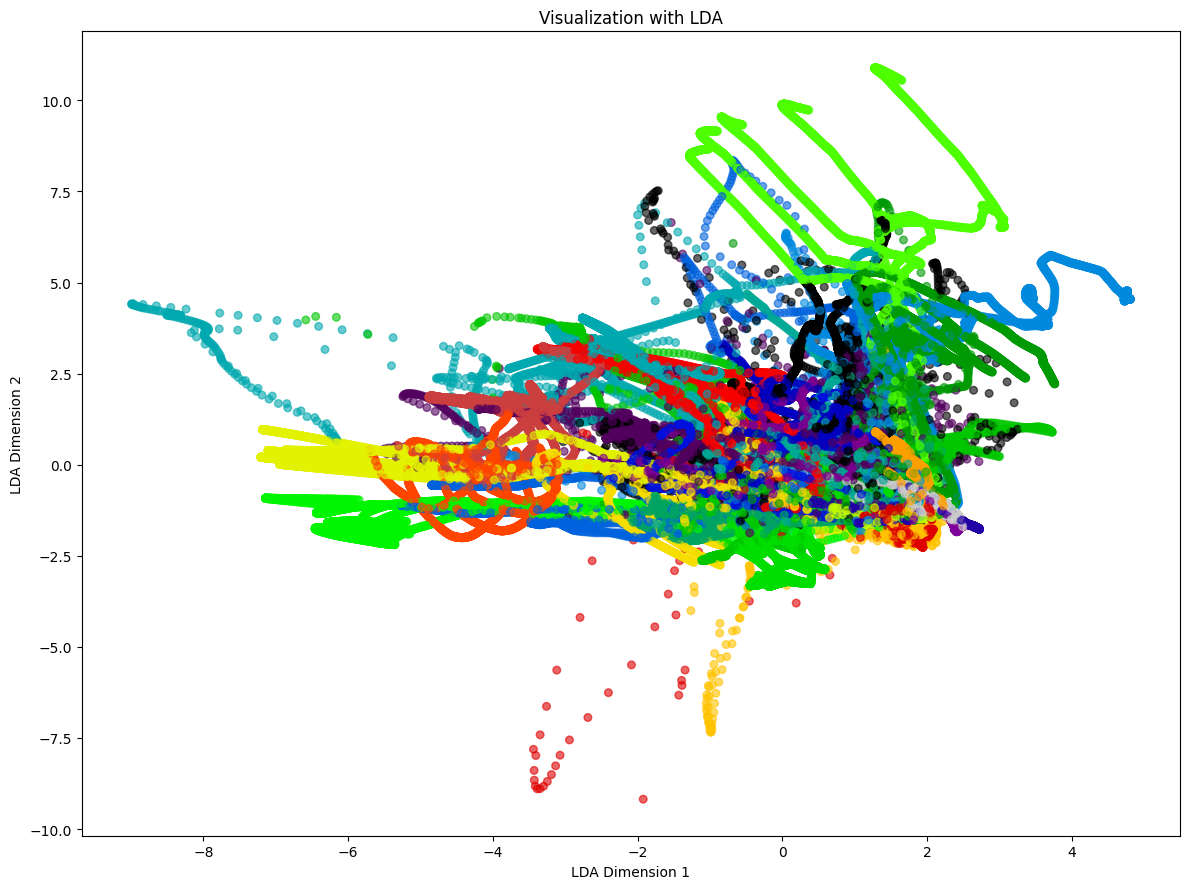

In [ ]:
plot_latent_space(latent_representations, labels, techniques=['LDA'])

In [ ]:
plot_latent_space(latent_representations, labels, techniques=['UMAP'])

In [ ]:
plot_latent_space(latent_representations, labels, techniques=['t-SNE'])

In [ ]:
n_features = latent_representations.shape[1]
n_classes = np.unique(combined_labels).size
print("Number of features:", n_features)
print("Number of classes:", n_classes)


Number of features: 16
Number of classes: 2


In [ ]:
# Concatenate real and synthetic data
combined_data = np.concatenate([scaled_data, generation], axis=0)

# Create labels for real data ('0') and synthetic data ('1')
real_labels = np.zeros(scaled_data.shape[0])  # Assuming 0 for real
synthetic_labels = np.ones(generation.shape[0])  # Assuming 1 for synthetic
combined_labels = np.concatenate([real_labels, synthetic_labels], axis=0)

# Generate latent representations for the combined dataset
latent_outputs = vae.encoder.predict(combined_data)
latent_representations = latent_outputs[0]  # Assuming the mean of the latent space is the first output

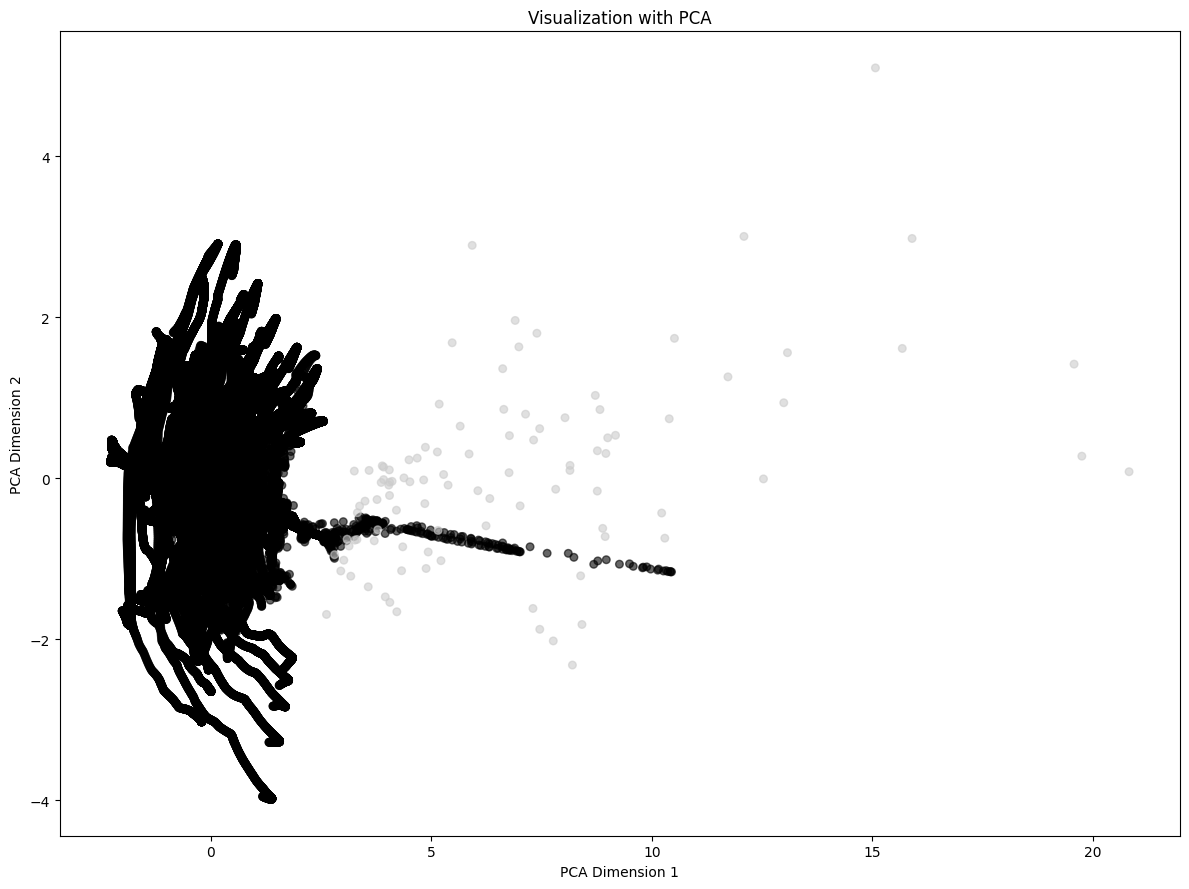

In [ ]:

# Plot latent space using the modified function
plot_latent_space(latent_representations, combined_labels, techniques=['PCA'], n_colors=2)

In [ ]:
print(vae.encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 300, 7)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 300, 64)              4544      ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 300, 64)              0         ['conv1d[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)           (None, 300, 64)              8256      ['dropout[0][0]']             
                                                                                            

In [ ]:
wandb.finish()